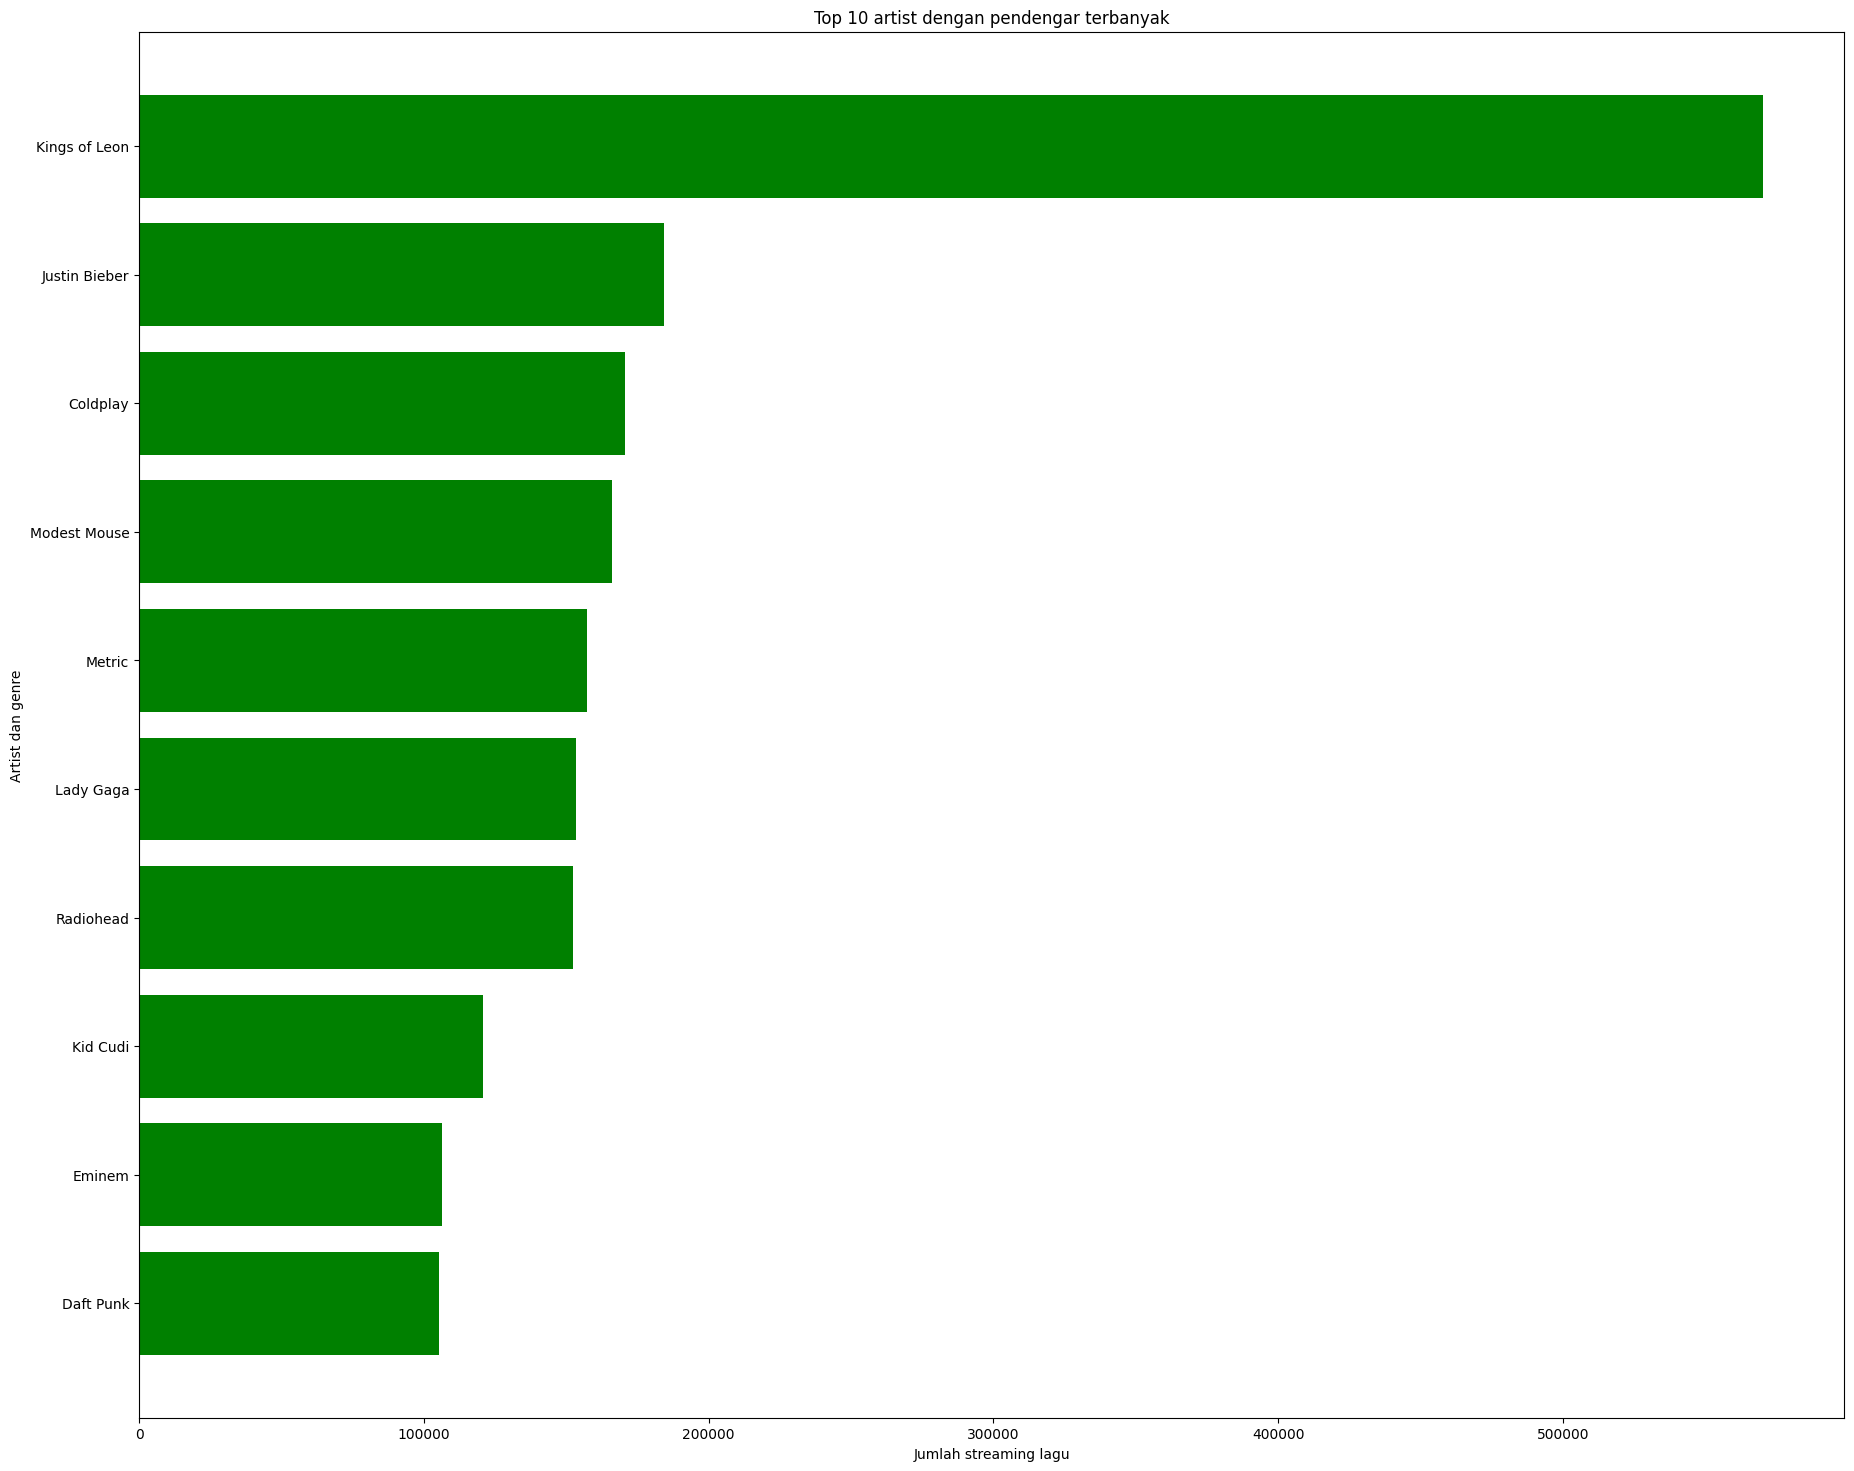

In [2]:
import csv
import matplotlib.pyplot as plt

occurrences = []
artist_and_category = []

# Baca data
with open('merged/merged_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        occurrences.append(int(row['occurrences']))
        artist_and_category.append(f"{row['artist']}")
        if occurrences.__len__() > 9:
            break

# Plotting
plt.figure(figsize=(22, 18))
plt.barh(artist_and_category, occurrences, color='green')
plt.xlabel('Jumlah streaming lagu')
plt.ylabel('Artist dan genre')
plt.title('Top 10 artist dengan pendengar terbanyak')
plt.gca().invert_yaxis()
plt.show()

C:\Users\manzi\AppData\Local\Temp\ipykernel_28936\1605879351.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_songs = df.groupby('genre').apply(lambda x: x.nlargest(5, 'occurrences')).reset_index(drop=True)


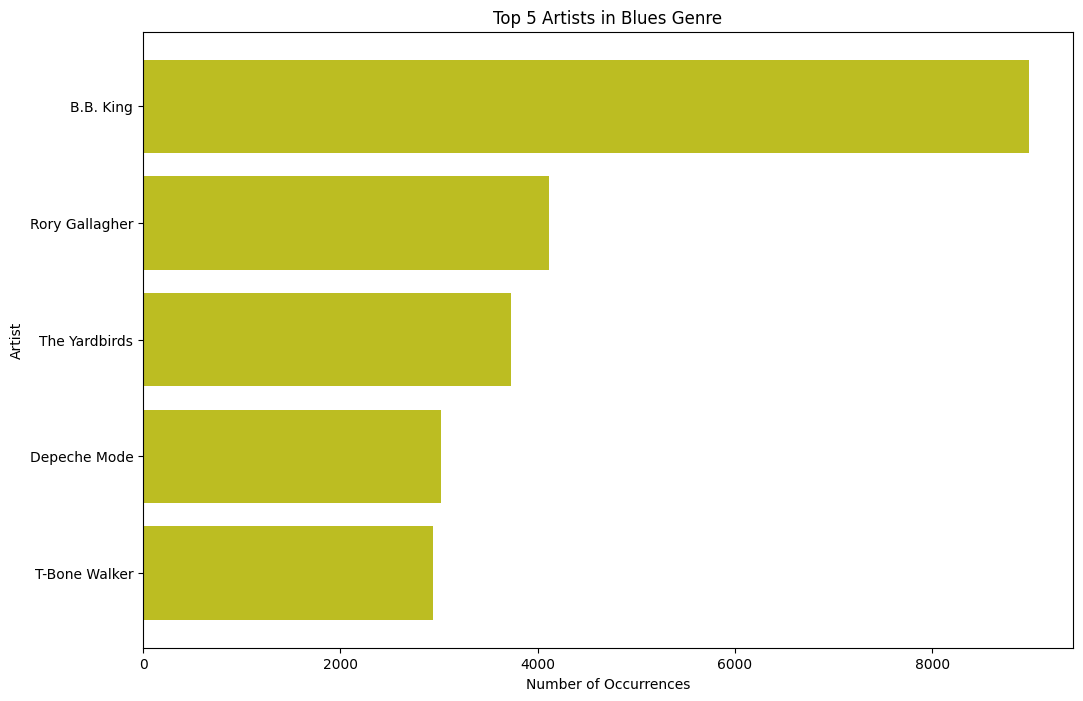

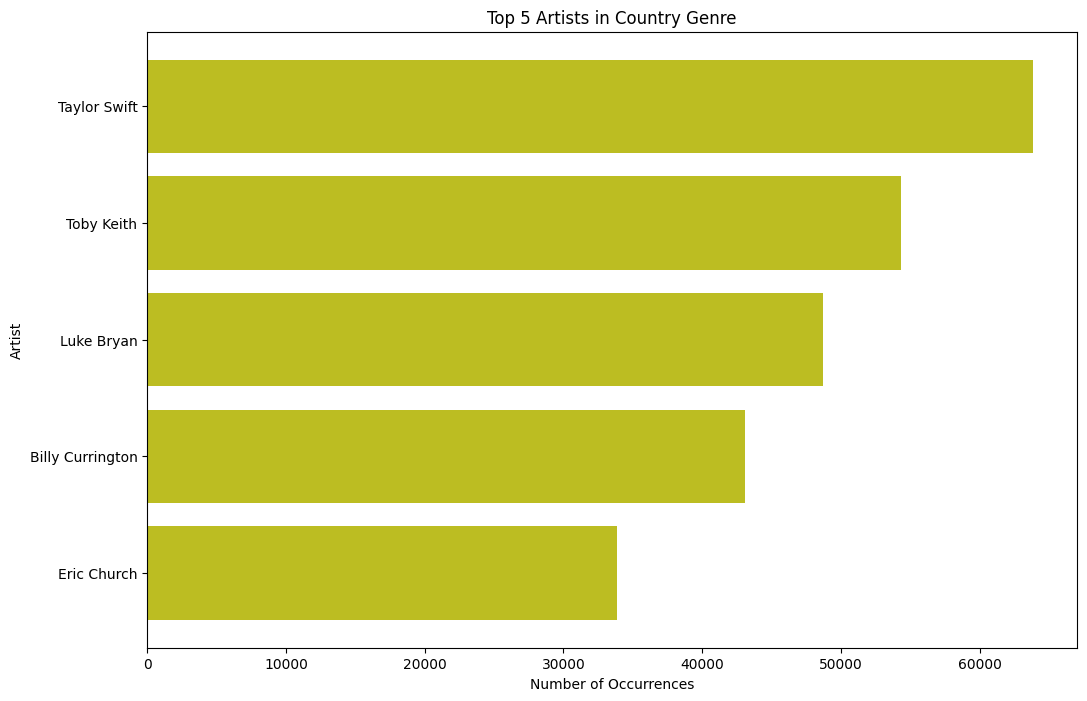

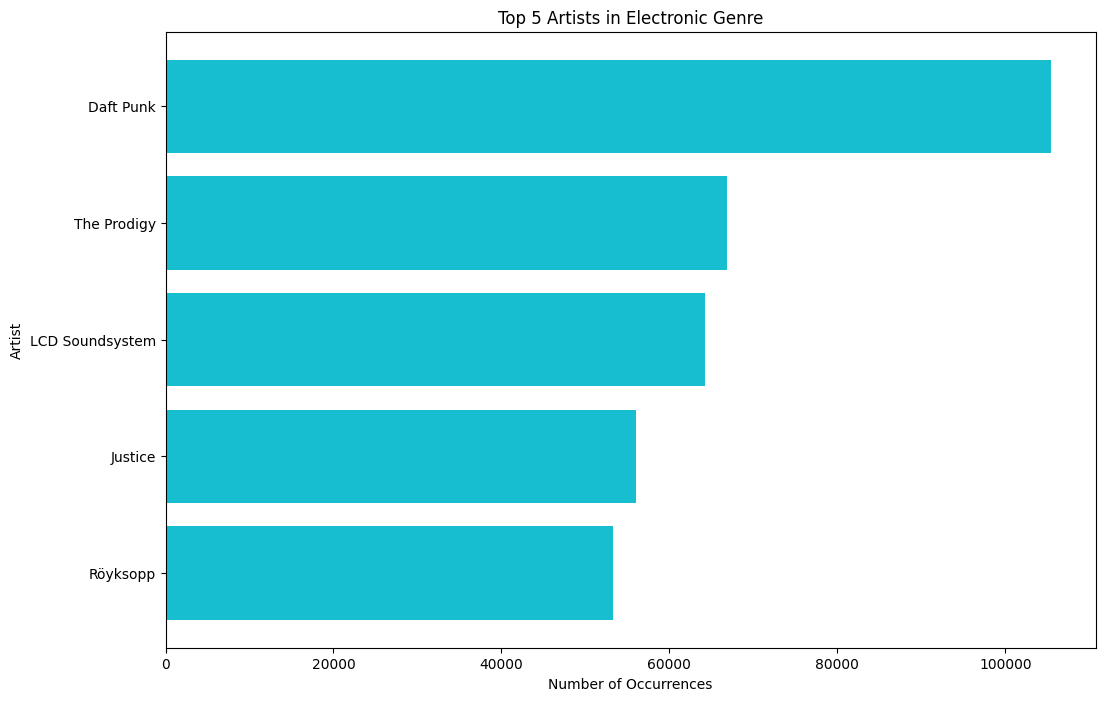

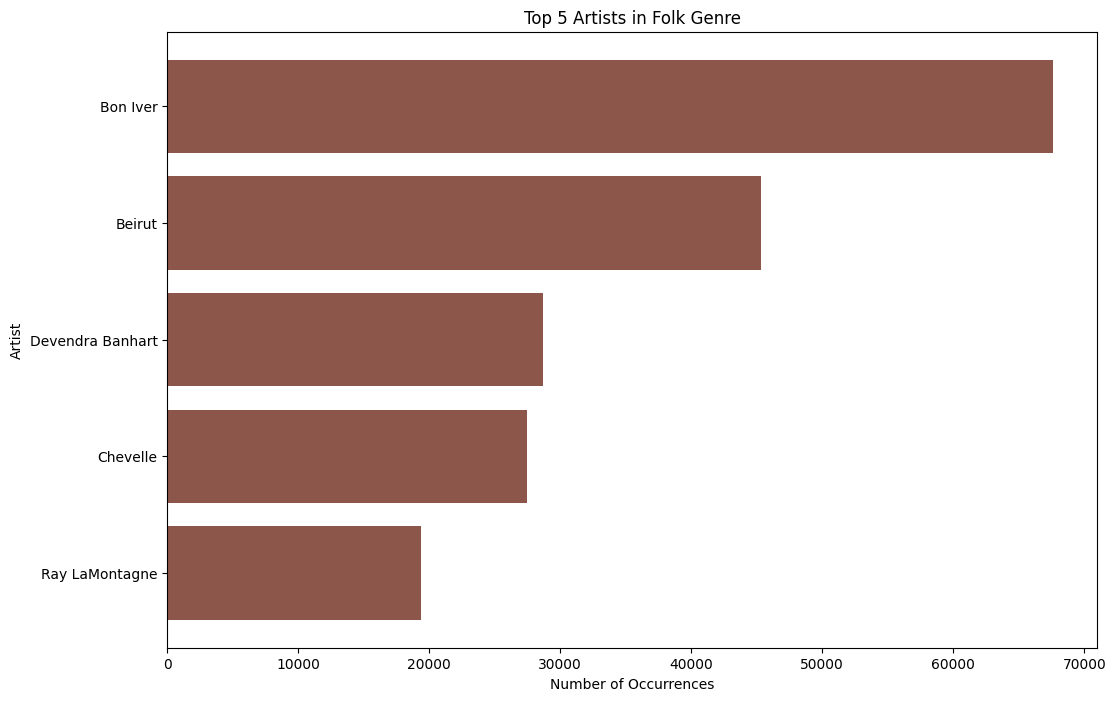

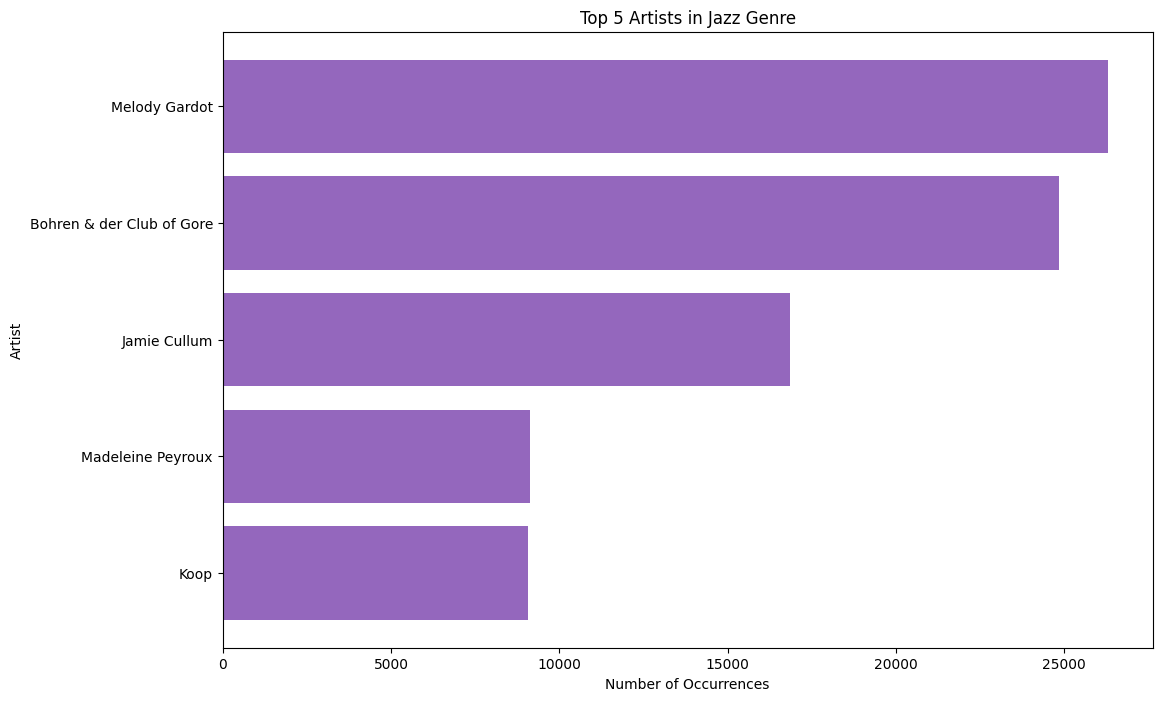

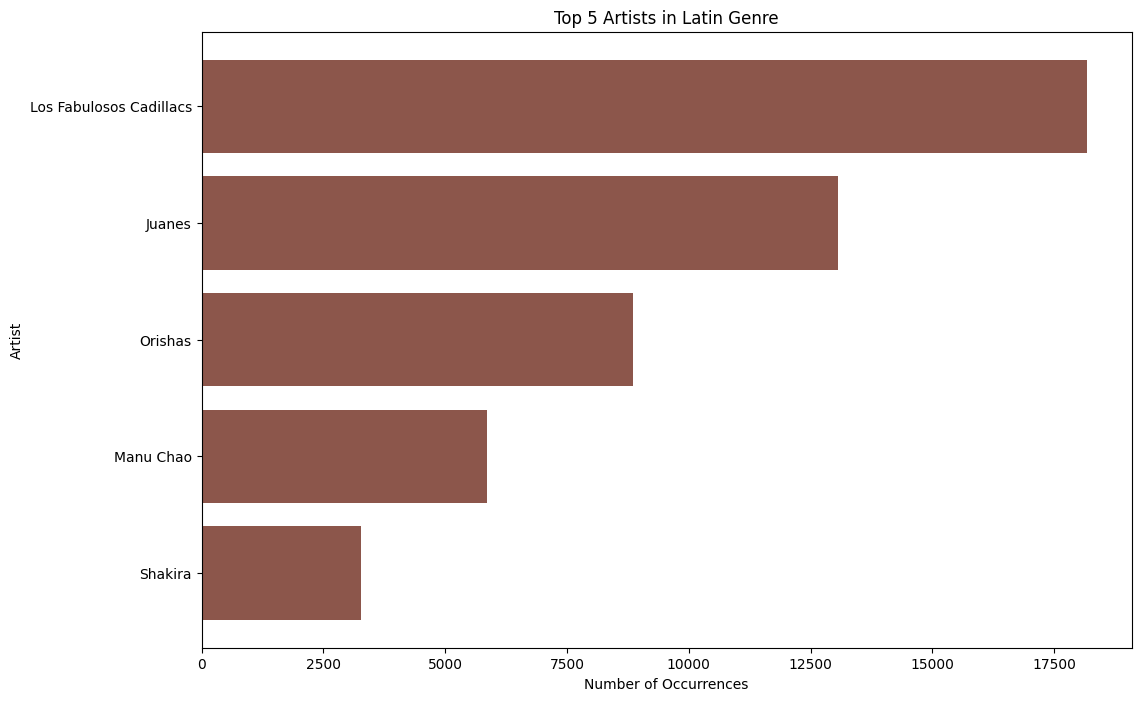

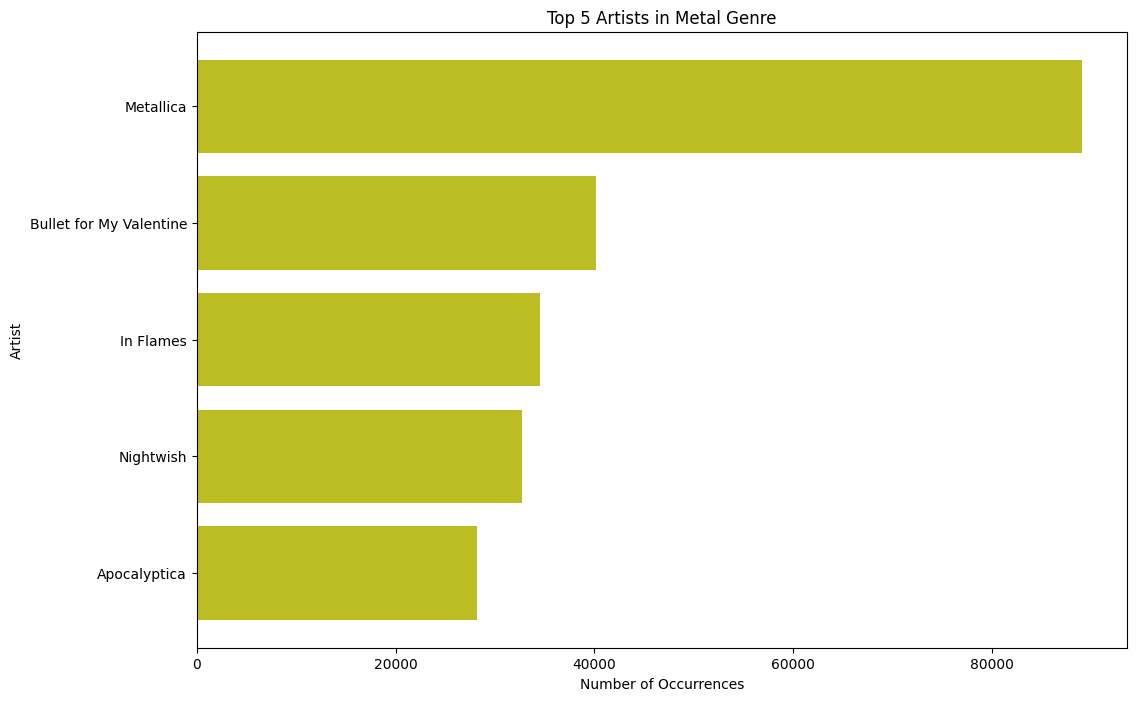

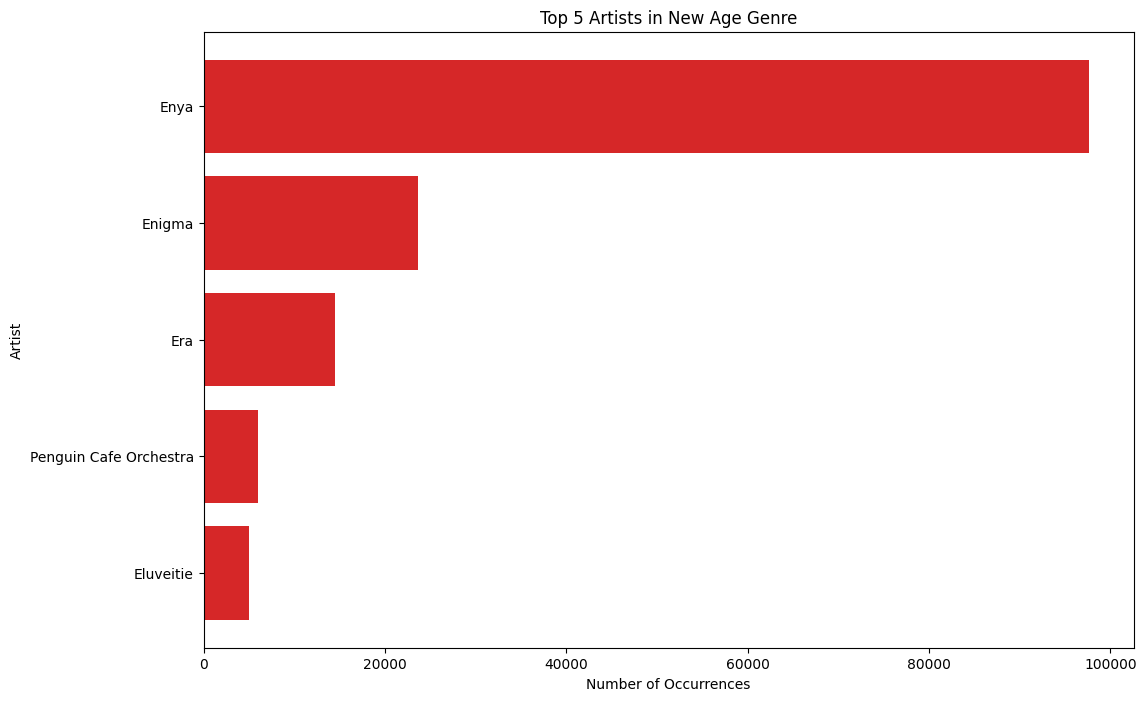

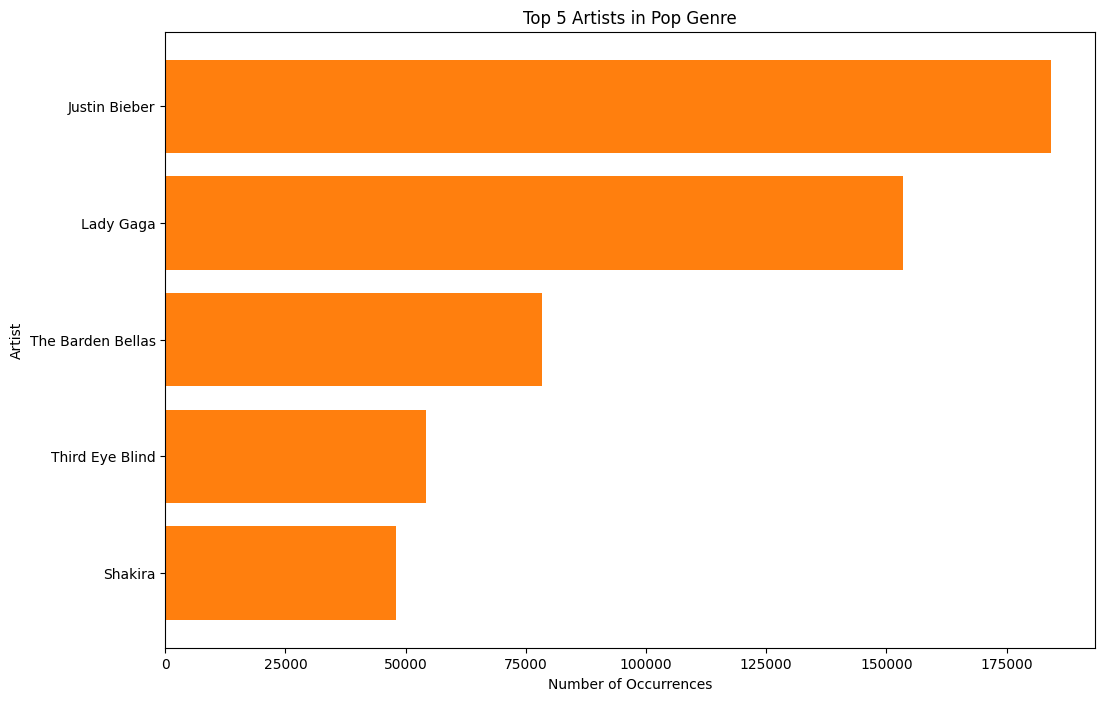

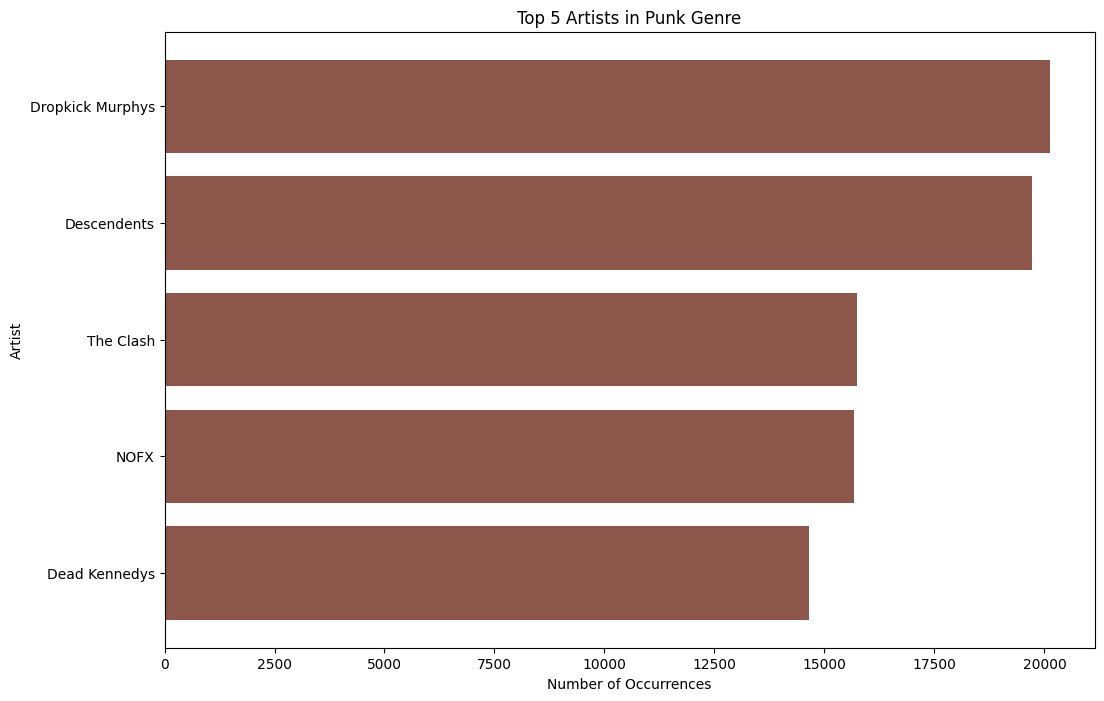

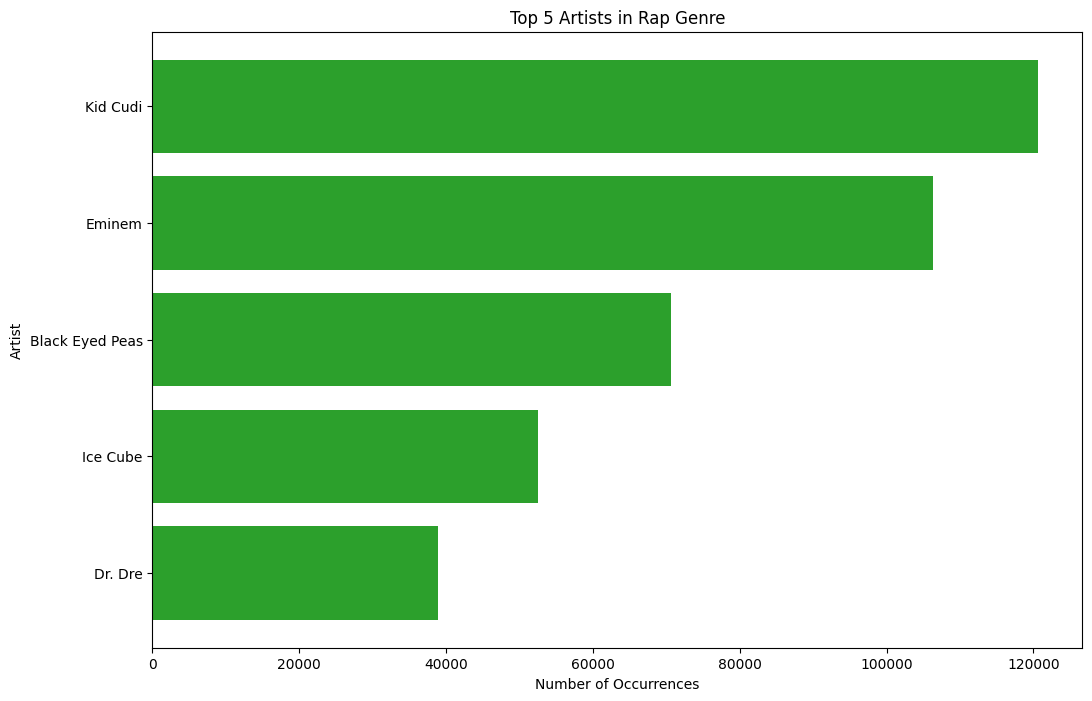

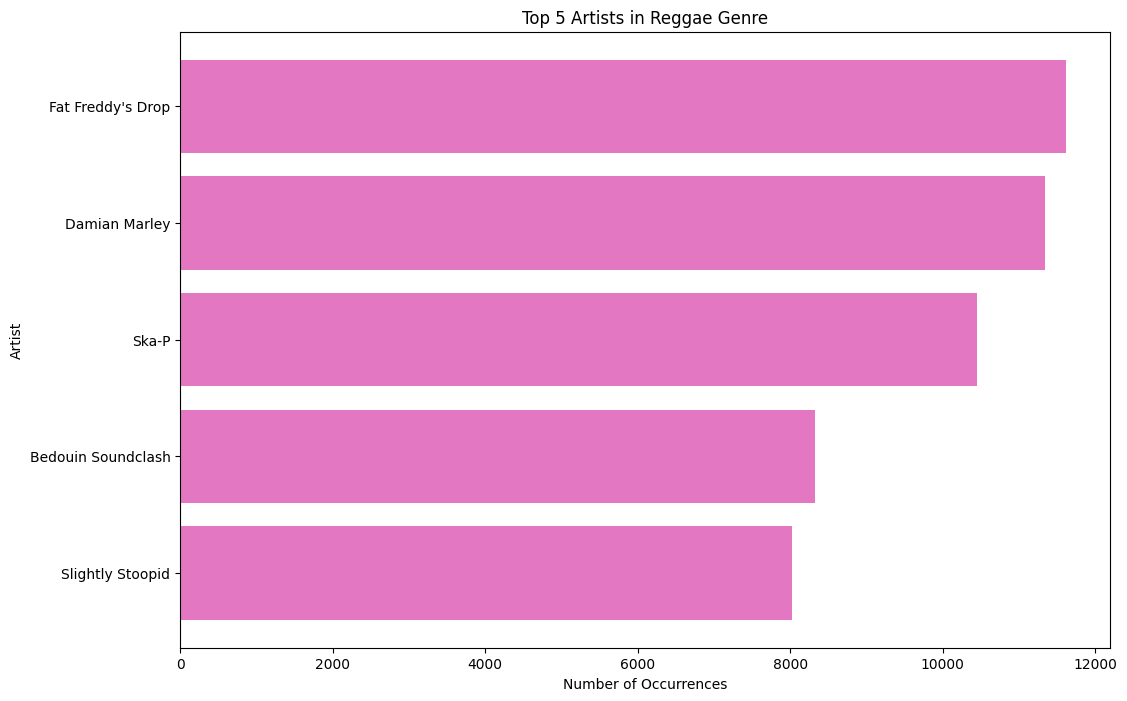

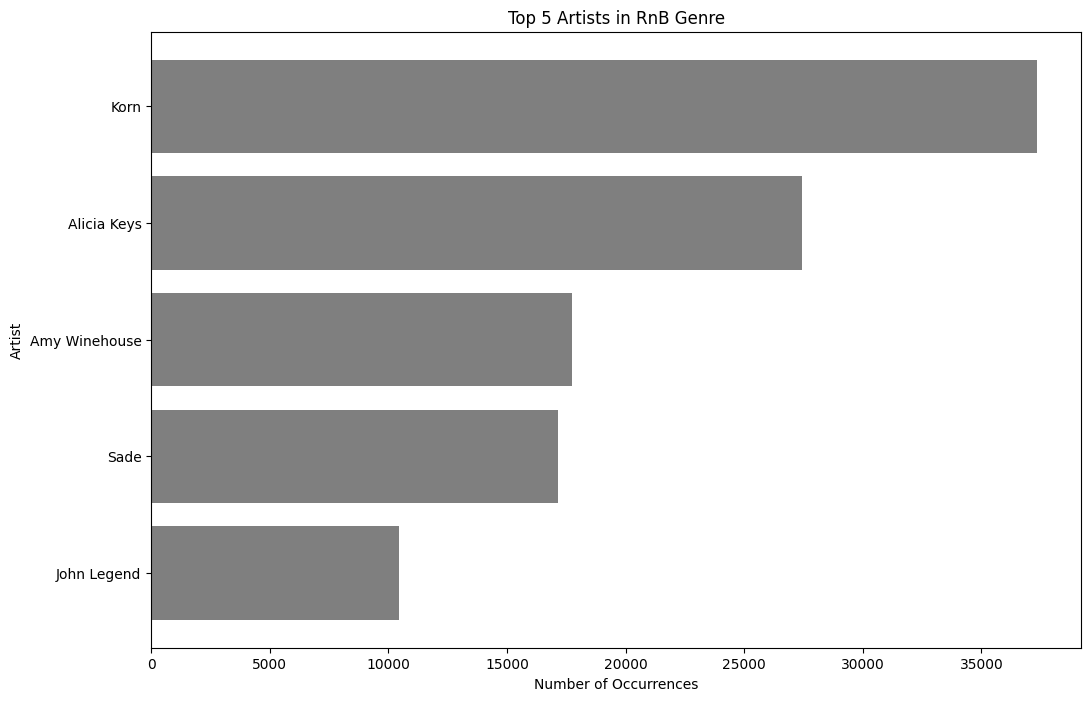

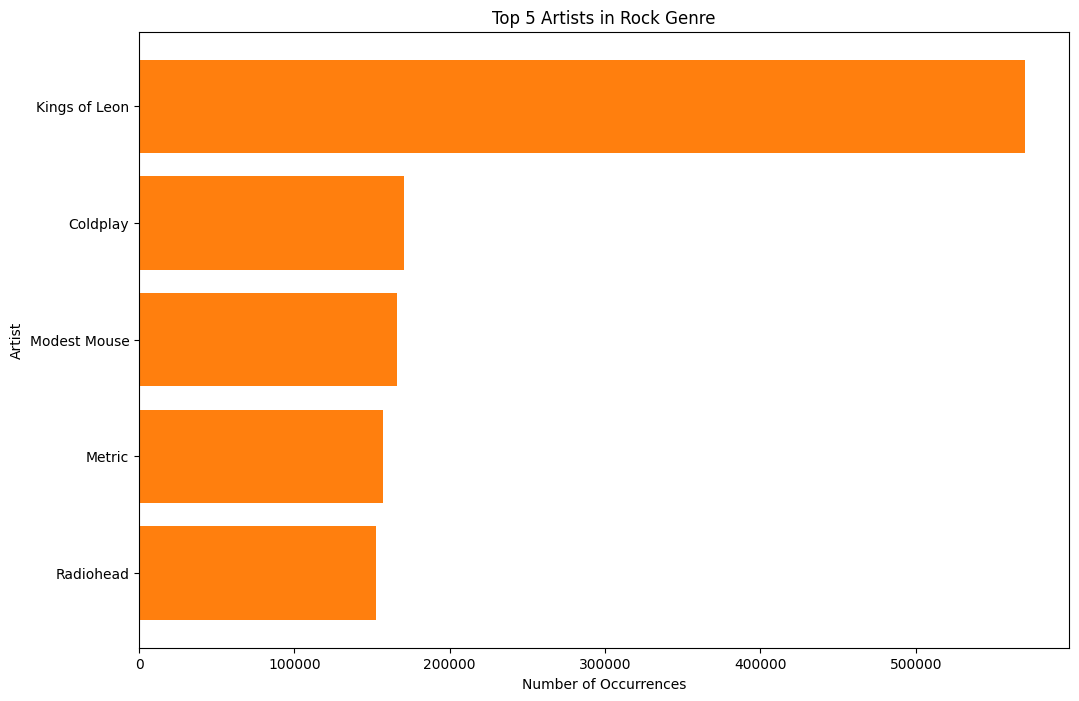

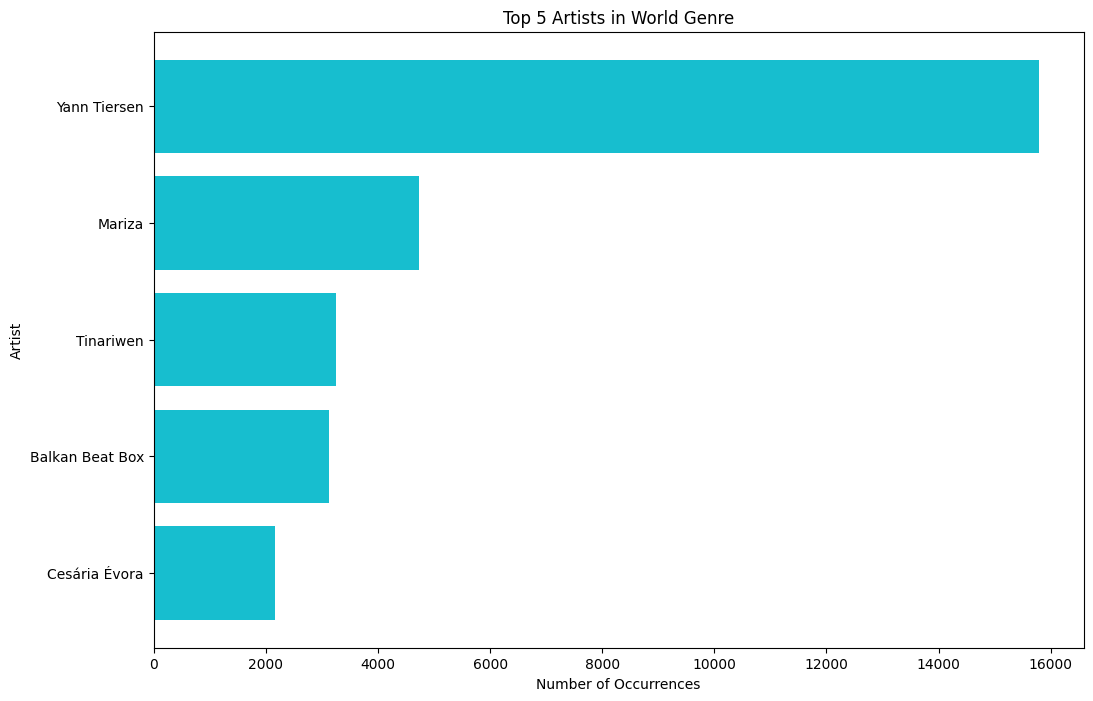

In [3]:
from random import randrange
import pandas as pd
import matplotlib.pyplot as plt

csv_file = 'merged/merged_data.csv'
df = pd.read_csv(csv_file)

# Grouping top 5 data dari genre
top_songs = df.groupby('genre').apply(lambda x: x.nlargest(5, 'occurrences')).reset_index(drop=True)

# Persiapan data
genre_data = {}
for index, row in top_songs.iterrows():
    genre = row['genre']
    if genre not in genre_data:
        genre_data[genre] = {'artists': [], 'occurrences': []}
    genre_data[genre]['artists'].append(row['artist'])
    genre_data[genre]['occurrences'].append(row['occurrences'])

# Warna untuk plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot data
for genre, data in genre_data.items():
    plt.figure(figsize=(12, 8))
    plt.barh(data['artists'], data['occurrences'], color=colors[randrange(0, len(colors))])
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Artist')
    plt.title(f'Top 5 Artists in {genre} Genre')
    plt.gca().invert_yaxis()
    plt.show()